In [150]:
import pandas as pd

df = pd.read_csv("ChatbotData .csv", encoding='utf-8-sig')

In [151]:
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [152]:
data = df.drop_duplicates()

In [153]:
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거 (영어는 소문자 변환)
    sentence = sentence.strip()

    # 구두점과 특수문자 사이에 공백 추가 (한국어에 맞게 처리)
    # 예를 들어서 "나는 학생입니다." => "나는 학생입니다 ."와 같이
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 다수의 공백을 하나로 축소
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 한국어와 특수문자(?, !, ., ,)를 제외한 모든 문자를 공백으로 대체
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    
    # 공백을 제거
    sentence = sentence.strip()
    
    return sentence

In [154]:
file_path = 'ChatbotData .csv'
def load_conversations(file_path, max_samples=10000):
    # 파일을 읽어옵니다.
    data = pd.read_csv(file_path)
    
    # 데이터가 질문과 답변의 형식으로 구성되어 있다고 가정합니다.
    inputs, outputs = [], []

    for i in range(len(data)):
        # 질문과 답변을 데이터 프레임에서 추출
        question = preprocess_sentence(data.iloc[i, 0])  # 첫 번째 컬럼이 질문
        answer = preprocess_sentence(data.iloc[i, 1])    # 두 번째 컬럼이 답변

        inputs.append(question)
        outputs.append(answer)

        if len(inputs) >= max_samples:
            break
    
    return inputs, outputs

In [155]:
import re
inputs, outputs = load_conversations(file_path)
print('전체 샘플 수 :', len(inputs))
print('전체 샘플 수 :', len(outputs))

전체 샘플 수 : 10000
전체 샘플 수 : 10000


In [156]:
print('전처리 후의 22번째 질문 샘플: {}'.format(inputs[1]))
print('전처리 후의 22번째 답변 샘플: {}'.format(outputs[1]))

전처리 후의 22번째 질문 샘플: 지망 학교 떨어졌어
전처리 후의 22번째 답변 샘플: 위로해 드립니다 .


In [157]:
import tensorflow_datasets as tfds
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(inputs + outputs, target_vocab_size=2**13)
print("슝=3 ")

슝=3 


In [158]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
END_TOKEN

[8816]

In [159]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8815]
END_TOKEN의 번호 : [8816]


In [160]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8817


In [161]:
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(inputs[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(outputs[21])))

정수 인코딩 후의 21번째 질문 샘플: [8533, 3642, 7119]
정수 인코딩 후의 21번째 답변 샘플: [1763, 5683, 7, 4724, 115, 1]


In [162]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 20
print(MAX_LENGTH)

20


In [163]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [165]:
questions, answers = tokenize_and_filter(inputs, outputs)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(inputs)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(outputs)))

단어장의 크기 : 8817
필터링 후의 질문 샘플 개수: 10000
필터링 후의 답변 샘플 개수: 10000


In [166]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [167]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")



슝=3


In [169]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    sines = tf.math.sin(angle_rads[:, 0::2])

    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [170]:
def scaled_dot_product_attention(query, key, value, mask):

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [171]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    outputs = self.dense(concat_attention)

    return outputs

In [172]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [173]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [174]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [175]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [176]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [177]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [178]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [179]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [180]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

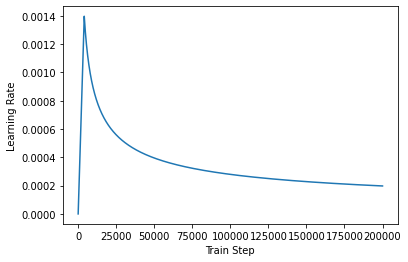

In [182]:
import matplotlib.pyplot as plt
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [189]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [191]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8817, 256)
(1, 8817, 256)


In [192]:
MAX_LENGTH = 8

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [193]:
EPOCHS = 100

model.fit(dataset, epochs=EPOCHS)

Epoch 1/100


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /tmp/ipykernel_31/3232998049.py:11 accuracy  *
        return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/metrics.py:3537 sparse_categorical_accuracy
        return tf.cast(tf.equal(y_true, y_pred), backend.floatx())
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1864 equal
        return gen_math_ops.equal(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:3217 equal
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3561 _create_op_internal
        ret = Operation(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 7 and 19 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](Reshape, Cast_2)' with input shapes: [?,7], [?,19].


In [195]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import re

urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")

train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [197]:
questions = []
for sentence in train_data['Q']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [198]:
answers = []
for sentence in train_data['A']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [199]:
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [202]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[19]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5766, 611, 6, 19, 3116, 55, 1]
기존 문장: 가스비 너무 많이 나왔다 .


In [203]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> 가스
611 ----> 비 
6 ----> 너무 
19 ----> 많이 
3116 ----> 나왔
55 ----> 다
1 ---->  .


In [204]:
MAX_LENGTH = 8

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)
  
  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [205]:
questions, answers = tokenize_and_filter(questions, answers)

In [206]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [207]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8180, 256)
(1, 8180, 256)


In [208]:
MAX_LENGTH = 8

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [209]:
EPOCHS = 100

model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
185/185 [==============================] - 13s 29ms/step - loss: 6.9373 - accuracy: 0.1392
Epoch 2/100
185/185 [==============================] - 5s 28ms/step - loss: 5.4549 - accuracy: 0.2757
Epoch 3/100
185/185 [==============================] - 5s 28ms/step - loss: 4.5018 - accuracy: 0.2830
Epoch 4/100
185/185 [==============================] - 5s 28ms/step - loss: 4.0920 - accuracy: 0.3076
Epoch 5/100
185/185 [==============================] - 5s 28ms/step - loss: 3.7791 - accuracy: 0.3277
Epoch 6/100
185/185 [==============================] - 5s 28ms/step - loss: 3.4666 - accuracy: 0.3521
Epoch 7/100
185/185 [==============================] - 5s 28ms/step - loss: 3.1390 - accuracy: 0.3871
Epoch 8/100
185/185 [==============================] - 5s 28ms/step - loss: 2.7904 - accuracy: 0.4297
Epoch 9/100
185/185 [==============================] - 5s 28ms/step - loss: 2.4214 - accuracy: 0.4724
Epoch 10/100
185/185 [==============================] - 5s 28ms/step - loss: 2.04

In [210]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [217]:
output = predict('내일 몇시까지 비가 오니?')

Input: 내일 몇시까지 비가 오니?
Output: 좋은차로 선택해보세요 .


In [216]:
loss, acc = model.evaluate(dataset, verbose=2)

# Print the evaluation results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

185/185 - 4s - loss: 0.0041 - accuracy: 0.8457
Test Loss: 0.004105091094970703
Test Accuracy: 0.8457365036010742
